In [ ]:
# Adapted from https://www.kaggle.com/code/ruchitass/predicting-stress-a-machine-learning-approach

In [3]:
!python --version

Python 3.9.19


In [5]:
import mlflow

In [7]:
mlflow.__version__

'2.12.2'

In [6]:
import xgboost

In [9]:
# import xgboost

In [8]:
import mlflow
import os

#os.environ["AWS_PROFILE"] = "dara" # fill in with your AWS profile. More info: https://docs.aws.amazon.com/sdk-for-java/latest/developer-guide/setup.html#setup-credentials

TRACKING_SERVER_HOST = "ec2-16-16-179-148.eu-north-1.compute.amazonaws.com" # fill in with the public DNS of the EC2 instance
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")

In [11]:
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

tracking URI: 'http://ec2-16-16-179-148.eu-north-1.compute.amazonaws.com:5000'


In [10]:
import kaggle

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re

# Download the stopwords resource
nltk.download('stopwords')

stemmer = nltk.SnowballStemmer("english")

from wordcloud import STOPWORDS
from PIL import Image
from wordcloud import WordCloud

# from textblob import TextBlob
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# import nltk
# import re
# stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
# import string

import matplotlib.pyplot as plt
import numpy as np


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# import warnings
# warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
!mkdir -p ~/.kaggle
!mv ~/mental_health_mlops_project/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mv: cannot stat '/home/ubuntu/mental_health_mlops_project/kaggle.json': No such file or directory


In [6]:
!kaggle datasets download -d ruchi798/stress-analysis-in-social-media

Dataset URL: https://www.kaggle.com/datasets/ruchi798/stress-analysis-in-social-media
License(s): other
 76%|█████████████████████████████         | 1.00M/1.31M [00:00<00:00, 1.62MB/s]
100%|██████████████████████████████████████| 1.31M/1.31M [00:00<00:00, 2.02MB/s]


In [7]:
!mv stress-analysis-in-social-media.zip ../../data/

In [8]:
# !unzip ../../data/stress-analysis-in-social-media.zip -d ../../data/ 

In [3]:
# !rm ../../data/stress-analysis-in-social-media.zip 

In [14]:
train = pd.read_csv("../../data/dreaddit-train.csv")
test = pd.read_csv("../../data/dreaddit-test.csv")

In [15]:
train["subreddit"].unique()

array(['ptsd', 'assistance', 'relationships', 'survivorsofabuse',
       'domesticviolence', 'anxiety', 'homeless', 'stress',
       'almosthomeless', 'food_pantry'], dtype=object)

In [16]:
train

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.800000,1521614353,5,1.806818,...,1.0000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.000000,1527009817,4,9.429737,...,1.1250,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.800000,1535935605,2,7.769821,...,1.0000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.600000,1516429555,0,2.667798,...,1.0000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.800000,1539809005,24,7.554238,...,1.0000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,relationships,7oee1t,"[35, 40]","* Her, a week ago: Precious, how are you? (I i...",1713,0,1.000000,1515187044,13,-1.369333,...,1.4000,1.0000,1.0,1.71133,1.45301,2.00304,0.84,16,0.254444,0.552066
2834,ptsd,9p4ung,"[20, 25]",I don't have the ability to cope with it anymo...,1133,1,1.000000,1539827412,33,9.425478,...,1.0000,1.0000,1.0,1.65003,1.56842,1.81527,0.96,6,8.640664,-0.220370
2835,anxiety,9nam6l,"(5, 10)",In case this is the first time you're reading ...,10442,0,1.000000,1539269312,2,11.060675,...,1.1250,1.1250,1.0,1.79768,1.49074,1.92286,1.00,1,9.951524,0.045455
2836,almosthomeless,5y53ya,"[5, 10]",Do you find this normal? They have a good rela...,1834,0,0.571429,1488938143,4,2.421912,...,1.1111,1.1429,1.0,1.71642,1.57627,1.89972,0.75,7,4.036765,0.159722


In [17]:
print("Rows :", train.shape[0])

Rows : 2838


In [18]:
print("Columns :", train.shape[1])

Columns : 116


In [19]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Columns: 116 entries, subreddit to sentiment
dtypes: float64(106), int64(6), object(4)
memory usage: 2.5+ MB
None


In [20]:
print(train.select_dtypes(include=['object']).apply(pd.Series.nunique, axis=0))

subreddit           10
post_id           2343
sentence_range     173
text              2820
dtype: int64


In [21]:
categorical_columns = list(train.select_dtypes(include=['object']).columns)

In [22]:
numerical_columns = [column for column in train.columns if column not in categorical_columns and column not in ['label']]

In [23]:
numerical_columns

['id',
 'confidence',
 'social_timestamp',
 'social_karma',
 'syntax_ari',
 'lex_liwc_WC',
 'lex_liwc_Analytic',
 'lex_liwc_Clout',
 'lex_liwc_Authentic',
 'lex_liwc_Tone',
 'lex_liwc_WPS',
 'lex_liwc_Sixltr',
 'lex_liwc_Dic',
 'lex_liwc_function',
 'lex_liwc_pronoun',
 'lex_liwc_ppron',
 'lex_liwc_i',
 'lex_liwc_we',
 'lex_liwc_you',
 'lex_liwc_shehe',
 'lex_liwc_they',
 'lex_liwc_ipron',
 'lex_liwc_article',
 'lex_liwc_prep',
 'lex_liwc_auxverb',
 'lex_liwc_adverb',
 'lex_liwc_conj',
 'lex_liwc_negate',
 'lex_liwc_verb',
 'lex_liwc_adj',
 'lex_liwc_compare',
 'lex_liwc_interrog',
 'lex_liwc_number',
 'lex_liwc_quant',
 'lex_liwc_affect',
 'lex_liwc_posemo',
 'lex_liwc_negemo',
 'lex_liwc_anx',
 'lex_liwc_anger',
 'lex_liwc_sad',
 'lex_liwc_social',
 'lex_liwc_family',
 'lex_liwc_friend',
 'lex_liwc_female',
 'lex_liwc_male',
 'lex_liwc_cogproc',
 'lex_liwc_insight',
 'lex_liwc_cause',
 'lex_liwc_discrep',
 'lex_liwc_tentat',
 'lex_liwc_certain',
 'lex_liwc_differ',
 'lex_liwc_percept

In [24]:
categorical_columns = [column for column in categorical_columns if column != 'text'] 

In [25]:
categorical_columns

['subreddit', 'post_id', 'sentence_range']

In [26]:
train[categorical_columns]

,subreddit,post_id,sentence_range
0,ptsd,8601tu,"(15, 20)"
1,assistance,8lbrx9,"(0, 5)"
2,ptsd,9ch1zh,"(15, 20)"
3,relationships,7rorpp,"[5, 10]"
4,survivorsofabuse,9p2gbc,"[0, 5]"
...,...,...,...
2833,relationships,7oee1t,"[35, 40]"
2834,ptsd,9p4ung,"[20, 25]"
2835,anxiety,9nam6l,"(5, 10)"
2836,almosthomeless,5y53ya,"[5, 10]"


In [30]:
# categorical_columns = ["subreddit"]

Only subreddit is selected, and post_id and sentence_range are dropped

In [28]:
train[numerical_columns]

,id,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,lex_liwc_Tone,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,33181,0.800000,1521614353,5,1.806818,116,72.64,15.04,89.26,1.00,...,1.0000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,2606,1.000000,1527009817,4,9.429737,109,79.08,76.85,56.75,98.18,...,1.1250,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,38816,0.800000,1535935605,2,7.769821,167,33.80,76.38,86.24,25.77,...,1.0000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,239,0.600000,1516429555,0,2.667798,273,2.98,15.25,95.42,79.26,...,1.0000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,1421,0.800000,1539809005,24,7.554238,89,32.22,28.71,84.01,1.00,...,1.0000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,1713,1.000000,1515187044,13,-1.369333,89,19.41,99.00,37.57,99.00,...,1.4000,1.0000,1.0,1.71133,1.45301,2.00304,0.84,16,0.254444,0.552066
2834,1133,1.000000,1539827412,33,9.425478,135,40.97,4.45,98.01,1.00,...,1.0000,1.0000,1.0,1.65003,1.56842,1.81527,0.96,6,8.640664,-0.220370
2835,10442,1.000000,1539269312,2,11.060675,134,79.52,97.34,2.27,80.01,...,1.1250,1.1250,1.0,1.79768,1.49074,1.92286,1.00,1,9.951524,0.045455
2836,1834,0.571429,1488938143,4,2.421912,68,29.74,61.58,21.06,25.77,...,1.1111,1.1429,1.0,1.71642,1.57627,1.89972,0.75,7,4.036765,0.159722


In [31]:
# No missing data
print(train.isnull().sum().sum())

0


In [32]:
# Assuming X contains your categorical features and y is the target variable
train_numerical = train[numerical_columns]  # Select your categorical features here
label = train['label']  # Target variable

# Calculate mutual information scores
mi_scores = mutual_info_classif(train_numerical, label)

# Create a DataFrame to display the scores
feature_scores = pd.DataFrame({
    'Feature': train_numerical.columns,
    'Score': mi_scores
})

# # Display sorted features by score
top_features = feature_scores.sort_values(by='Score', ascending=False).head(5)
selected_features = top_features['Feature'].tolist()


In [33]:
numerical_columns = selected_features

In [34]:
# numerical_columns 

In [35]:
feature_scores.sort_values(by='Score', ascending=False, inplace=True)
print(feature_scores[:10])

                      Feature     Score
9               lex_liwc_Tone  0.113758
36            lex_liwc_negemo  0.087908
7              lex_liwc_Clout  0.083212
16                 lex_liwc_i  0.076278
110                 sentiment  0.060857
101  lex_dal_min_pleasantness  0.049885
35            lex_liwc_posemo  0.046449
66              lex_liwc_risk  0.038845
40            lex_liwc_social  0.037753
6           lex_liwc_Analytic  0.036108


In [36]:
# Standardization
scaler = StandardScaler()
# X_numerical = scaler.fit_transform(train_numerical)

In [37]:
def process_numerical_features(df):
    X_numerical = df[numerical_columns]
    X_numerical = scaler.fit_transform(train_numerical)
    return X_numerical
    

In [38]:
# train

In [39]:
# X_train = train[["subreddit", "sentence_range","text","id"]]

In [40]:
# y = train["label"]

In [41]:
import string
#Get a list of punctuations
punct = []
for char in string.punctuation:
    punct.append(char)

In [42]:
# #Sentiment Detection
# def mood(txt):
#     return TextBlob(txt).sentiment.polarity

In [43]:
def removal(text):
    text = str(text).lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [w for w in text.split(' ') if w not in stopwords]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

In [44]:

vect=CountVectorizer(stop_words="english")

In [45]:
def process_categorical_features(df, vect = None):
    posts = train[["text"]]
    posts["text"] = posts["text"].apply(removal)
    # posts["sentiment"] = posts["text"].apply(mood)
    X = posts["text"]
    if vect:
        print("here")
        X = vect.transform(X)
    else:
        vect=CountVectorizer(stop_words="english")
        X=vect.fit_transform(X)
    return X, vect
    

In [46]:
def prepare_features(df, vect=None):
    X_categorical, vect = process_categorical_features(train, vect)
    X_numerical = process_numerical_features(train)
    X_combined = np.hstack((X_categorical.toarray(), X_numerical))

    return X_combined
    
    

In [47]:
X_combined = prepare_features(train)

/tmp/ipykernel_2988/2518064960.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts["text"] = posts["text"].apply(removal)


In [48]:
X_combined.shape

(2838, 9559)

In [40]:
# X, vect = process_categorical_features(x_train, vect)

In [41]:
# posts = train[["text"]]

In [42]:
# posts

In [93]:
# stopwords

In [94]:
# [w for w in train.text[0].split()]

In [225]:
# from nltk.corpus import stopwords
# stopwords = set(stopwords.words("english"))

In [311]:
# #Adding Mood Detection as column
# posts["sentiment"] = posts["text"].apply(mood)
# posts.head()

In [312]:
# train["sentiment"]

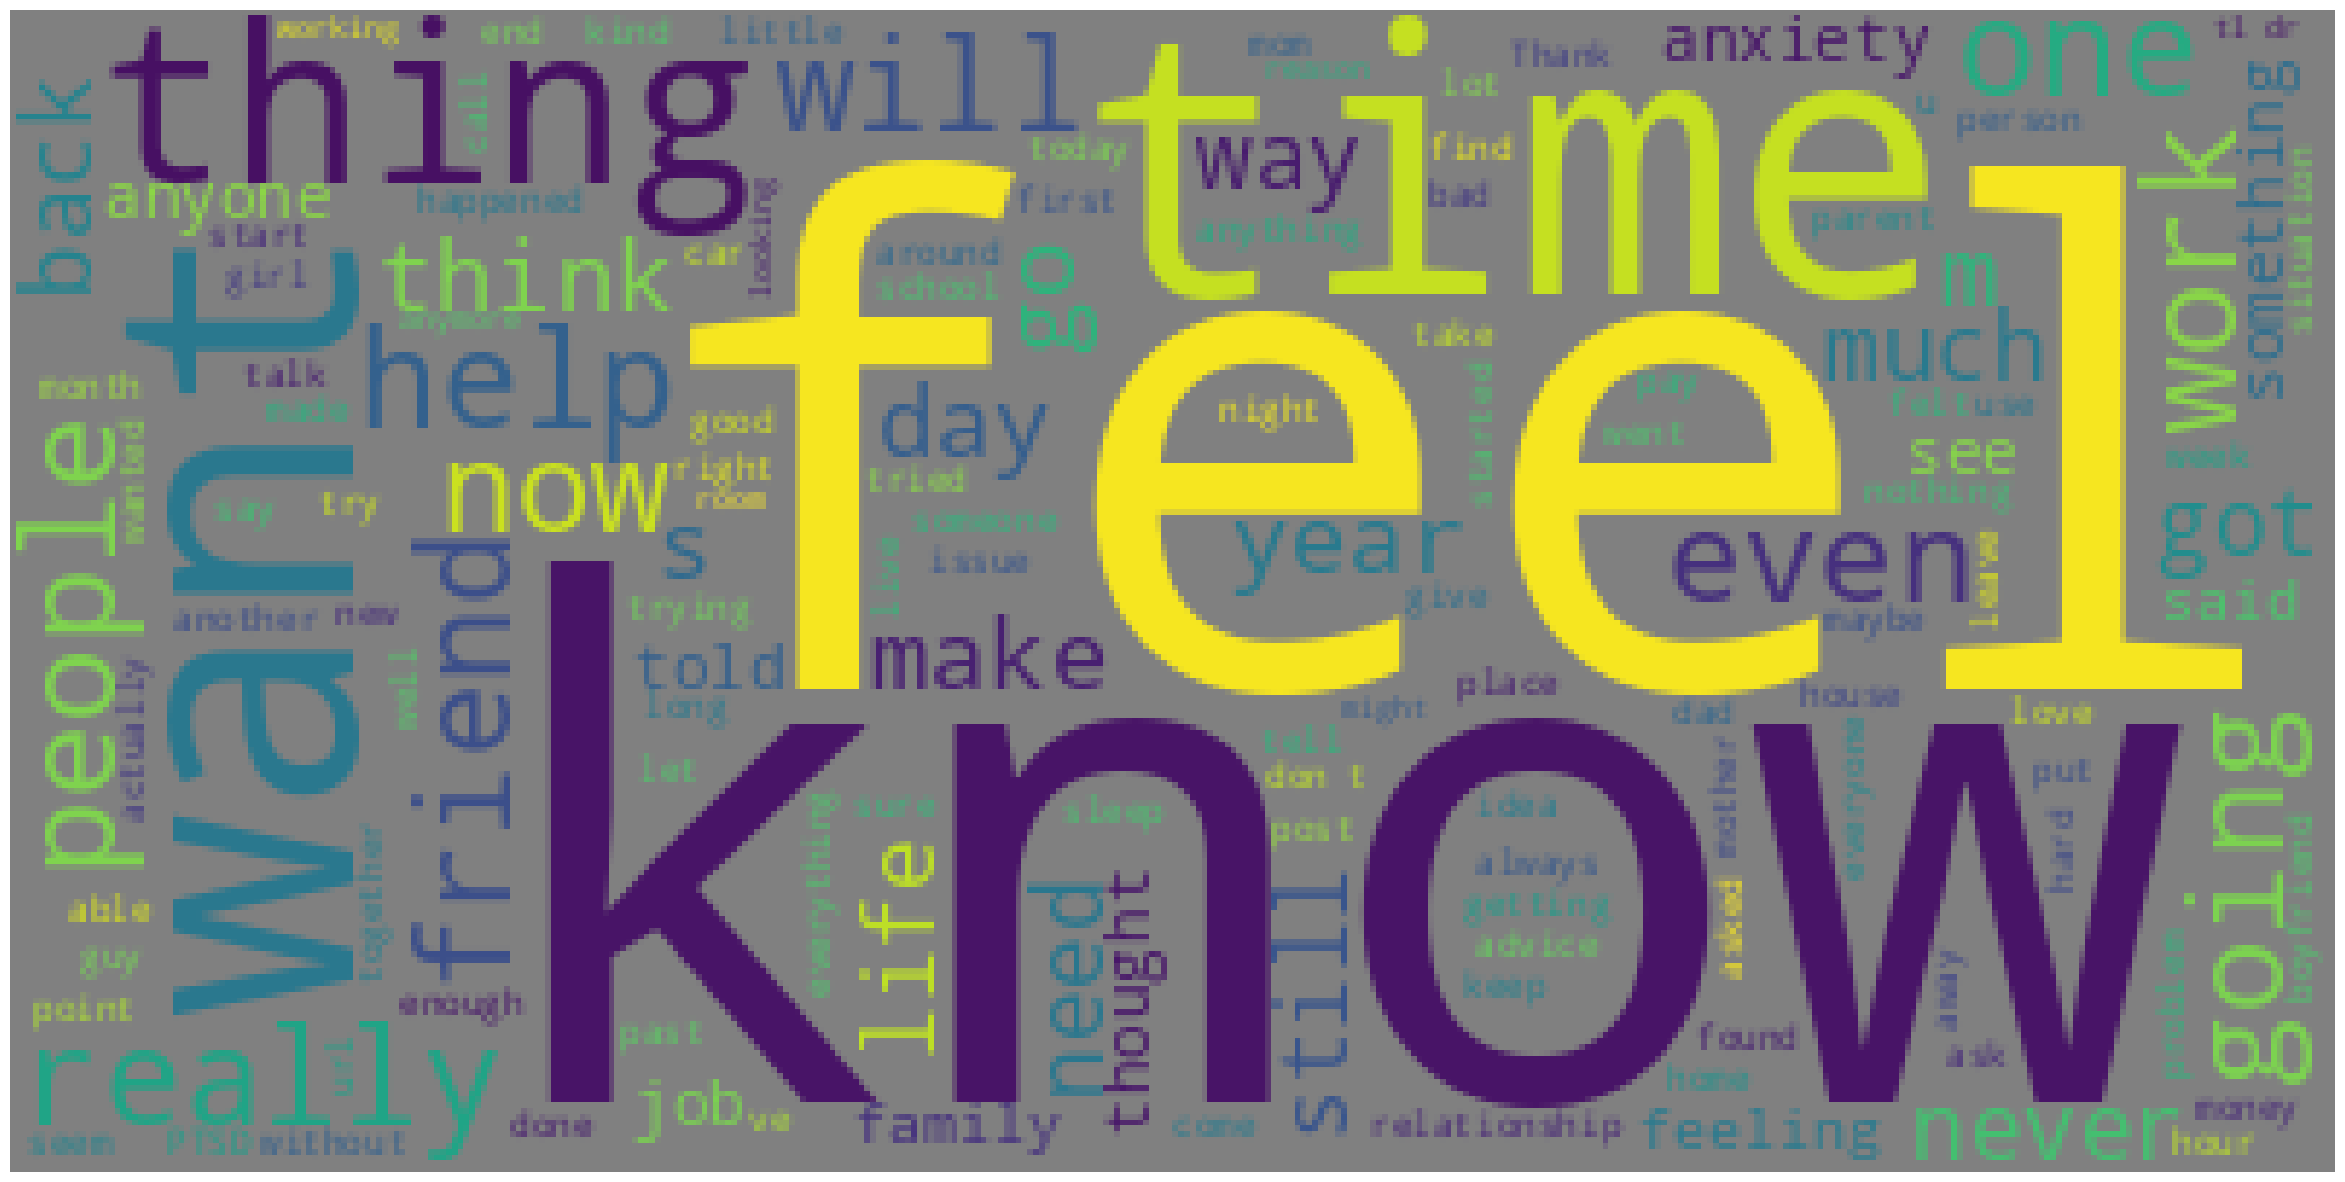

In [55]:
#Wordcloud
def wc(data,bgcolor):
    plt.figure(figsize=(30,30))
    #mask=np.array(Image.open('/kaggle/input/stressanalysisinsocialmedia/stress-954814_960_720.png'))
    wc=WordCloud(background_color=bgcolor,stopwords=STOPWORDS)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis("off")
wc(train.text,'grey')

In [56]:
#Adding meaning to text from og dataset
train["meaning"] = train["label"].map({0:"Unstressed", 1:"Stressed"})
#posts = posts[["text", "meaning"]]
# posts.head()

In [57]:
value_counts = train["meaning"].value_counts()

<Axes: xlabel='meaning'>

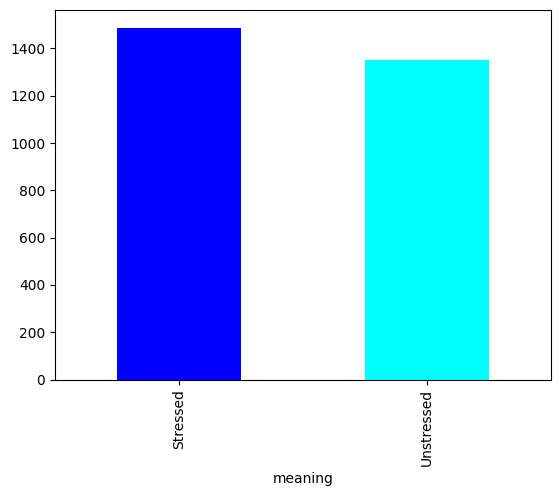

In [58]:
value_counts.plot(kind='bar', color=['blue', 'cyan'])



In [59]:
# y = posts["meaning"]
y = train['label']

In [60]:
X_text_features, vect = process_categorical_features(train)

/tmp/ipykernel_2988/2518064960.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts["text"] = posts["text"].apply(removal)


In [61]:
X_text_features.toarray().shape

(2838, 9448)

In [62]:
x_train_combined,x_test_combined,y_train,y_test=train_test_split(X_combined,y,random_state=43)
# x_train,x_test,y_train,y_test=train_test_split(train[numerical_columns + categorical_columns],y,random_state=43)

In [63]:
X_combined.shape

(2838, 9559)

In [64]:
# X_text_features

In [65]:
x_train_text,x_test_text,y_train,y_test=train_test_split(X_text_features.toarray(),y,random_state=43)

In [67]:
x_train_combined

array([[ 0.        ,  0.        ,  0.        , ..., -0.22705845,
         0.27279517, -0.35461566],
       [ 0.        ,  0.        ,  0.        , ...,  0.09412805,
         0.95003374, -0.11250743],
       [ 0.        ,  0.        ,  0.        , ..., -0.45647737,
        -0.79034871,  0.79654045],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.41059359,
        -0.49591487,  0.80506753],
       [ 0.        ,  0.        ,  0.        , ..., -0.31882602,
        -0.3971096 , -1.21341466],
       [ 0.        ,  0.        ,  0.        , ..., -0.18117466,
         0.04525364,  1.04504399]])

In [54]:
# X_numerical = process_numerical_features(x_train)

In [55]:
# X_numerical

In [68]:
mb=MultinomialNB()
mb.fit(x_train_text,y_train)
y_pred= mb.predict(x_test_text)

print(f"Model Accuracy for Naive Bayes is {round (accuracy_score(y_pred,y_test)*100, 2)}%")



Model Accuracy for Naive Bayes is 70.85%


In [308]:
# mb=MultinomialNB()
# mb.fit(x_train,y_train)
# y_pred= mb.predict(x_test)

# print(f"Model Accuracy for Naive Bayes is {round (accuracy_score(y_pred,y_test)*100, 2)}%")

In [69]:

logistic_reg =LogisticRegression().fit(x_train_text, y_train)
y_pred= logistic_reg.predict(x_test_text)
print(f"Model Accuracy for logistic regression is {round (accuracy_score(y_pred,y_test)*100, 2)}%")

Model Accuracy for logistic regression is 67.46%


In [70]:
logistic_reg =LogisticRegression(max_iter=1000).fit(x_train_combined, y_train)
y_pred= logistic_reg.predict(x_test_combined)
print(f"Model Accuracy for logistic regression is {round (accuracy_score(y_pred,y_test)*100, 2)}%")

Model Accuracy for logistic regression is 72.82%


In [71]:

tree=DecisionTreeClassifier()
tree.fit(x_train_text,y_train)
y_pred=tree.predict(x_test_text)
print(f"Model Accuracy for Decision Tree is {round (accuracy_score(y_test,y_pred)*100, 2)}%")

Model Accuracy for Decision Tree is 61.69%


In [73]:
tree=DecisionTreeClassifier()
tree.fit(x_train_combined,y_train)
y_pred=tree.predict(x_test_combined)
print(f"Model Accuracy for Decision Tree is {round (accuracy_score(y_test,y_pred)*100, 2)}%")

Model Accuracy for Decision Tree is 65.49%


In [74]:
clf = GaussianNB()
clf.fit(x_train_text, y_train)
y_pred=clf.predict(x_test_text)
print(f"Model Accuracy for Gaussian Naive Bayes is {round (accuracy_score(y_test,y_pred)*100, 2)}%")

Model Accuracy for Gaussian Naive Bayes is 62.11%


In [76]:
clf = GaussianNB()
clf.fit(x_train_combined, y_train)
y_pred=clf.predict(x_test_combined)
print(f"Model Accuracy for Gaussian Naive Bayes is {round (accuracy_score(y_test,y_pred)*100, 2)}%")


Model Accuracy for Gaussian Naive Bayes is 61.97%


In [77]:
# Create Random Forest classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier on the training data
clf_rf.fit(x_train_text, y_train)

# Make predictions on the test data
y_pred_rf = clf_rf.predict(x_test_text)

# Evaluate accuracy of the classifier
accuracy_rf = round (accuracy_score(y_pred_rf,y_test)*100, 2)
print(f"Random Forest Accuracy: {accuracy_rf}" )

Random Forest Accuracy: 66.06


In [78]:
# Create Random Forest classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier on the training data
clf_rf.fit(x_train_combined, y_train)

# Make predictions on the test data
y_pred_rf = clf_rf.predict(x_test_combined)

# Evaluate accuracy of the classifier
accuracy_rf = round (accuracy_score(y_pred_rf,y_test)*100, 2)
print(f"Random Forest Accuracy: {accuracy_rf}" )



Random Forest Accuracy: 73.8


In [82]:
clf_xgb = XGBClassifier(n_estimators=100, random_state=42)

# Fit the classifier on the training data
clf_xgb.fit(x_train_text, y_train)

# Make predictions on the test data
y_pred_xgb = clf_xgb.predict(x_test_text)

# Evaluate accuracy of the classifier
accuracy_xgb = round (accuracy_score(y_pred_xgb,y_test)*100, 2)
print(f"XGBoost Accuracy:: {accuracy_xgb}" )
# accuracy_xgb = accuracy_score(y_pred_xgb, y_test)
# print("XGBoost Accuracy:", accuracy_xgb)

XGBoost Accuracy:: 67.75


In [84]:
clf_xgb = XGBClassifier(n_estimators=100, random_state=42)

# Fit the classifier on the training data
clf_xgb.fit(x_train_combined, y_train)

# Make predictions on the test data
y_pred_xgb = clf_xgb.predict(x_test_combined)

# Evaluate accuracy of the classifier
accuracy_xgb = round (accuracy_score(y_pred_xgb,y_test)*100, 2)
print(f"XGBoost Accuracy:: {accuracy_xgb}" )
# accuracy_xgb = accuracy_score(y_pred_xgb, y_test)
# print("XGBoost Accuracy:", accuracy_xgb)

XGBoost Accuracy:: 75.49


In [144]:
#Using Decision Trees
prompt = "Sometime I feel like I need some time"
p = vect.transform([prompt]).toarray()
op = mb.predict(p)
print(op)

['Stressed']


In [145]:
posts

,text,sentiment,meaning
0,"said felt way before, sugget go rest ..trigger...",0.027273,Stressed
1,"hey r/assistance, sure right place post this.....",0.360714,Unstressed
2,"mom hit newspap shock would this, know like pl...",0.199273,Stressed
3,"met new boyfriend, amazing, kind, sweet, good ...",0.190156,Stressed
4,octob domest violenc awar month domest violenc...,-0.085714,Stressed
...,...,...,...
2833,"* her, week ago: precious, you? (i ignor her.)...",0.424545,Unstressed
2834,"abil cope anymore. i'm trying, lot thing trigg...",0.090000,Stressed
2835,case first time read post... look peopl will c...,-0.051786,Unstressed
2836,find normal? good relationship. main problem s...,0.139583,Unstressed


In [146]:
prompt = "The weather is pleasant"
p = vect.transform([prompt]).toarray()
op = logistic_reg.predict(p)
print(op)

['Unstressed']


In [120]:
train

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.800000,1521614353,5,1.806818,...,1.0000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.000000,1527009817,4,9.429737,...,1.1250,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.800000,1535935605,2,7.769821,...,1.0000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.600000,1516429555,0,2.667798,...,1.0000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.800000,1539809005,24,7.554238,...,1.0000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,relationships,7oee1t,"[35, 40]","* Her, a week ago: Precious, how are you? (I i...",1713,0,1.000000,1515187044,13,-1.369333,...,1.4000,1.0000,1.0,1.71133,1.45301,2.00304,0.84,16,0.254444,0.552066
2834,ptsd,9p4ung,"[20, 25]",I don't have the ability to cope with it anymo...,1133,1,1.000000,1539827412,33,9.425478,...,1.0000,1.0000,1.0,1.65003,1.56842,1.81527,0.96,6,8.640664,-0.220370
2835,anxiety,9nam6l,"(5, 10)",In case this is the first time you're reading ...,10442,0,1.000000,1539269312,2,11.060675,...,1.1250,1.1250,1.0,1.79768,1.49074,1.92286,1.00,1,9.951524,0.045455
2836,almosthomeless,5y53ya,"[5, 10]",Do you find this normal? They have a good rela...,1834,0,0.571429,1488938143,4,2.421912,...,1.1111,1.1429,1.0,1.71642,1.57627,1.89972,0.75,7,4.036765,0.159722


In [ ]:
X_combined = np.hstack((x_train.toarray(), X_numerical))